In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
from matplotlib.cm import get_cmap
import math 

In [3]:
# Load the data into a dataframe

Mode = ["Aligned", "Alignedv2"]
# Mode = ["Rotated", "Rot30v2"] 
# Mode = ["Shifted","Shiftedv2"]
# Mode = ["Disk","Disk"]
# Mode = ["CRAB","CRAB"]

data = pd.read_csv(f"../Files/{Mode[0]}/EventInfo_merge_{Mode[1]}.csv", delimiter = ",", names = ["event", "x", "y", "z", "t"])

# Cut the first bin
data = data[data['t'] > 200]
display(data)

# Load the data into a dataframe
meta = pd.read_csv(f"../Files/{Mode[0]}/Metadata_merge_{Mode[1]}.csv", delimiter = ",", names = ["event","electrons","ions","elastic","ionisations","attachment","inelastic","excitation","top","bottom","start x","start y","start z", "start E", "end E"])

display(meta)

event      x      y      z        t
0            21  0.407  0.232  0.504  3285.91
1            21  0.415  0.234  0.491  3332.39
2            21  0.414  0.233  0.490  3335.14
3            21  0.413  0.232  0.489  3337.25
4            21  0.416  0.232  0.477  3403.79
...         ...    ...    ...    ...      ...
41195516  20000 -0.097 -0.357 -0.517  7752.81
41195517  20000 -0.098 -0.358 -0.516  7756.96
41195518  20000 -0.099 -0.358 -0.515  7762.39
41195519  20000 -0.100 -0.358 -0.514  7764.45
41195520  20000 -0.099 -0.357 -0.513  7765.04

[41193525 rows x 5 columns]

event  electrons  ions    elastic  ionisations  attachment  inelastic  \
0         21          1     0  408058018            0           0          0   
1         22          1     0  413685438            0           0          0   
2         23          1     0  387837241            0           0          0   
3         24          1     0  378874172            0           0          0   
4         25          1     0  409783954            0           0          0   
...      ...        ...   ...        ...          ...         ...        ...   
39915  19996          1     0  355026348            0           0          0   
39916  19997          1     0  367089033            0           0          0   
39917  19998          1     0  387798734            0           0          0   
39918  19999          1     0  377357718            0           0          0   
39919  20000          1     0  390596890            0           0          0   

       excitation  top  bottom   start x   start y  start z   start E  \
0            1039    0       1  0.410589  0.157936     0.85  1.000000   
1            1022    0       1 -0.157715  0.224725     0.85  8.679480   
2            1013    0       1  0.284188  0.305848     0.85  1.938208   
3            1047    0       1  0.367905 -0.029396     0.85  3.035464   
4            1023    0       1  0.357818 -0.239819     0.85  6.918574   
...           ...  ...     ...       ...       ...      ...       ...   
39915        1099    0       1  0.109435 -0.416635     0.85  4.258840   
39916        1064    0       1  0.189803 -0.228414     0.85  2.221994   
39917        1021    0       1 -0.196005  0.274152     0.85  4.094686   
39918        1037    0       1 -0.077307 -0.351011     0.85  3.712962   
39919        1013    0       1 -0.103632 -0.333988     0.85  2.729626   

          end E  
0      1.604425  
1      1.931269  
2      5.097305  
3      8.085884  
4      1.912164  
...         ...  
39915  2.417280  
39916  8.168886  
39917  6.913299  
39918  5.044169  
39919  5.602591  

[39920 rows x 15 columns]

In [4]:
# Print some additional info
print("ions: ", meta['ions'].sum())
print("Ionisations: ", meta['ionisations'].sum())
print("attachment: ", meta['attachment'].sum())
print("inelastic: ", meta['inelastic'].sum())
print("top: ", meta['top'].sum())
print("bottom: ", meta['bottom'].sum())
print("Mean VuV: ", meta['excitation'].mean())
print("STD/Mean VuV: ", 100*meta['excitation'].std()/meta['excitation'].mean())


ions:  0
Ionisations:  0
attachment:  0
inelastic:  0
top:  0
bottom:  39920
Mean VuV:  1031.9519288577155
STD/Mean VuV:  3.4200904359025297


In [5]:
# Here we subtract off the first time bin to shift all the EL values to zero
data_copy = data.copy(deep=True)

data_sub = data_copy.drop_duplicates(subset= ["event"], keep='first')
data_sub = data_sub.drop(columns = ["x", "y", "z"])

data_copy['Count'] = 1
data_copy = data_copy.groupby(["event"]).Count.count().reset_index()

# get a dataframe with the first time row to subtract from
data_merge = pd.DataFrame()
data_sub = data_sub.merge(data_copy, on='event', how="inner")
data_sub = data_sub.reset_index(drop = True)
data_sub = data_sub.loc[data_sub.index.repeat(data_sub.Count)]
data_sub = data_sub.drop(columns = ["Count"])
data_sub = data_sub.rename(columns={"t": "t_sub"})
data_sub = data_sub.reset_index(drop=True)


data = data.reset_index(drop=True)
data["t"] = data["t"] - data_sub["t_sub"]

In [6]:
# Bin the scatters in time
tmin=0
tmax=5000
tbw=50

tot_tracks = (len(data['event'].unique()))

tbins = np.arange(tmin, tmax+tbw, tbw)
tbins_centre = np.arange(tmin+tbw/2, tmax+tbw/2, tbw)


data['t'] = pd.cut(x=data['t'], bins=tbins,labels=tbins_centre, include_lowest=True)
display(data)

# Now average over the events
avg = data.groupby(['t']).count()
avg = avg.fillna(0)
avg.reset_index(inplace=True) 
display(avg)

std = data.groupby(['t']).std()
std = std.fillna(0)
std.reset_index(inplace=True) 
display(std)


event      x      y      z       t
0            21  0.407  0.232  0.504    25.0
1            21  0.415  0.234  0.491    25.0
2            21  0.414  0.233  0.490    25.0
3            21  0.413  0.232  0.489    75.0
4            21  0.416  0.232  0.477   125.0
...         ...    ...    ...    ...     ...
41193520  20000 -0.097 -0.357 -0.517  4275.0
41193521  20000 -0.098 -0.358 -0.516  4275.0
41193522  20000 -0.099 -0.358 -0.515  4275.0
41193523  20000 -0.100 -0.358 -0.514  4275.0
41193524  20000 -0.099 -0.357 -0.513  4275.0

[41193525 rows x 5 columns]

t   event       x       y       z
0     25.0   98351   98351   98351   98351
1     75.0  108144  108144  108144  108144
2    125.0  178928  178928  178928  178928
3    175.0  262092  262092  262092  262092
4    225.0  345837  345837  345837  345837
..     ...     ...     ...     ...     ...
95  4775.0    2325    2325    2325    2325
96  4825.0    1984    1984    1984    1984
97  4875.0    1511    1511    1511    1511
98  4925.0    1303    1303    1303    1303
99  4975.0    1027    1027    1027    1027

[100 rows x 5 columns]

t         event         x         y         z
0     25.0  11558.846847  0.237298  0.238856  0.010339
1     75.0  11538.015044  0.240409  0.236805  0.009461
2    125.0  11543.864745  0.240904  0.237524  0.010359
3    175.0  11525.660348  0.239509  0.238219  0.011246
4    225.0  11548.011891  0.238746  0.239452  0.012229
..     ...           ...       ...       ...       ...
95  4775.0  11993.158941  0.250304  0.261947  0.003605
96  4825.0  11364.715712  0.261988  0.242785  0.003497
97  4875.0  11691.837070  0.250560  0.253980  0.003654
98  4925.0  11362.439109  0.263625  0.247410  0.003361
99  4975.0  11964.028459  0.265653  0.255757  0.003435

[100 rows x 5 columns]

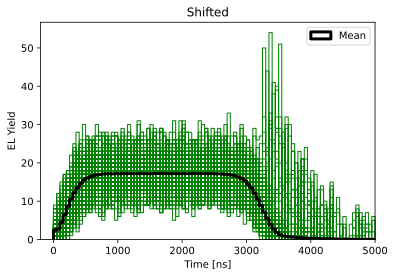

In [7]:
# Make a plot of the timing profile of the EL emission
plt.figure()

# New dataframe for storing binned hist details
data_binned = pd.DataFrame()

count = 0

for i in data['event'].unique():
    if (count > 300): break

    # Plot the data
    counts, bins, bars  = plt.hist(data[data["event"] == i]['t'], bins = np.arange(tmin, tmax+tbw, tbw), histtype="step", color = "green")
    # counts, edges  = np.histogram(data[data["event"] == i]['t'], bins = np.arange(tmin, tmax+tbw, tbw))
    
    # Save binned info to a histogram
    temp_df =  pd.DataFrame({'event': np.ones(len(counts))*i,
                   'Yield': counts,
                   'Time': tbins_centre })
    
    data_binned = pd.concat([data_binned,temp_df])
    count+=1

plt.hist(avg['t'], weights = avg['event']/tot_tracks,bins = np.arange(tmin, tmax+tbw, tbw), histtype="step", color = "black", linewidth=3, label="Mean")
plt.xlim(-200, 5000)
# plt.ylim(0, 20)

plt.xlabel("Time [ns]")
plt.ylabel("EL Yield")
plt.title(Mode[1])
plt.title("Shifted")
plt.legend()
plt.savefig("../Plots/"+Mode[0]+"/Yield_vs_Time.pdf")
# plt.title(f"Total VUV:{nVuV}")



Text(0, 0.5, 'EL Yield')

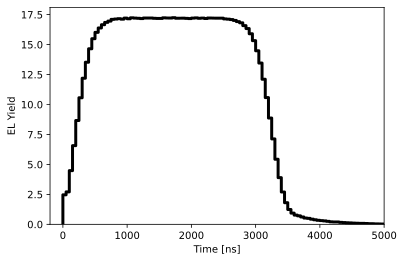

In [8]:
# Plot the average histogram
plt.figure()
plt.hist(avg['t'], weights = avg['event']/tot_tracks,bins = np.arange(tmin, tmax+tbw, tbw), histtype="step", color = "black", linewidth=3, label="Mean")
plt.xlim(-200, 5000)
plt.xlabel("Time [ns]")
plt.ylabel("EL Yield")

ValueError: autodetected range of [nan, nan] is not finite

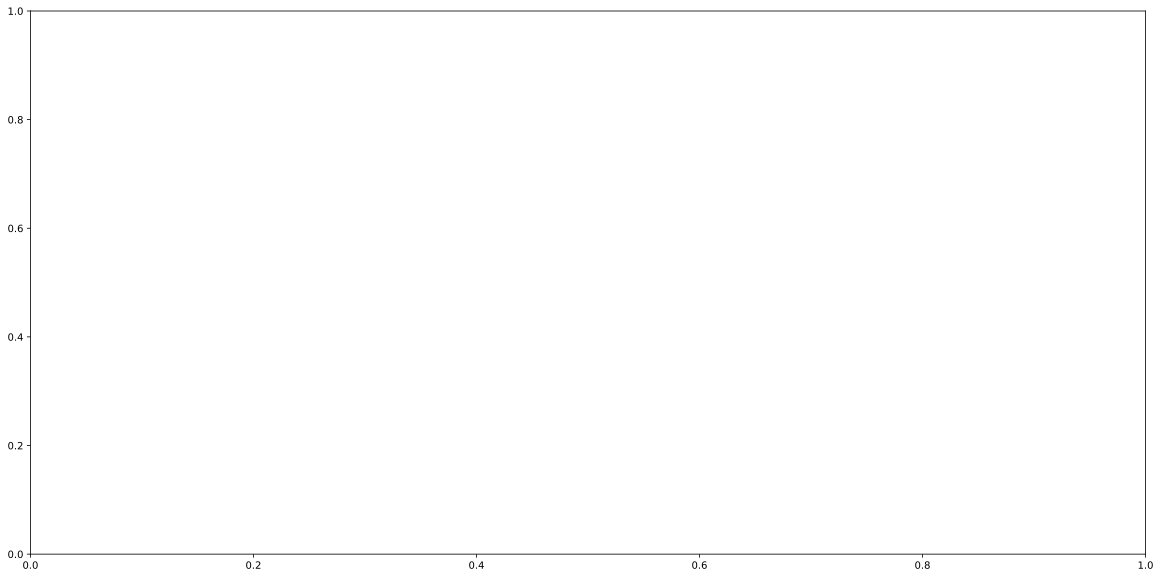

In [9]:
# Plot the z position vs time
plt.figure(figsize=(20, 10))
plt.hist2d(data["t"], data["z"], bins = 98)
plt.axhline(y = -11.343, color = 'r', linestyle = '--')
plt.axhline(y = -10.63, color = 'r', linestyle = '--')
plt.xlabel("Time [ns]")
plt.ylabel("z [cm]")



Empty DataFrame
Columns: [event, Yield, Time]
Index: []

Text(0, 0.5, 'z [cm]')

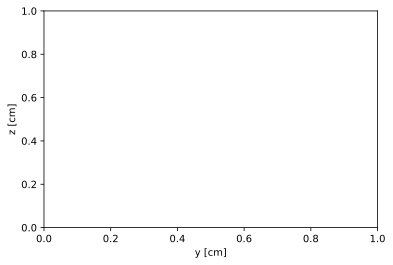

In [ ]:
display(data_binned[data_binned['Yield'] > 160])
evt_highY = data_binned[data_binned['Yield'] > 120]['event'].unique()

fig = plt.figure()
ax = fig.add_subplot()

for i in evt_highY:
    ax.plot(data[data["event"] == i]['y'], data[data["event"] == i]['z'])

ax.set_xlabel("y [cm]")
ax.set_ylabel("z [cm]")



In [24]:
# Make a plot of the timing profile of the EL emission
fig = plt.figure()
ax = fig.add_subplot()

# Create a sequential colormap
cmap = get_cmap('viridis')  # You can choose any sequential colormap here

count = 0
for i in data['event'].unique():
    if (count > 250): break
    ax.plot(data[data["event"] == i]['x'], data[data["event"] == i]['z'], color=cmap(count/250.))
    count+=1

plt.axhline(y = 0.5, color = 'black', linestyle = '--')
plt.axhline(y = -0.5, color = 'black', linestyle = '--')
# plt.axhline(y = -0.53, color = 'black', linestyle = '--')
# ax.set_zlim(-0.8, 0.7)
# ax.set_xlim(-0.7, 0.7)
# ax.set_ylim(-0.7, 0.7)
# ax.invert_xaxis()
ax.set_title("Inelastic Scatters")

ax.set_xlabel("x [cm]")
ax.set_ylabel("z [cm]")
# ax.set_zlabel("z [cm]")
plt.savefig("../Plots/"+Mode[0]+"/Inelastic_Scatters.pdf")

print(data.z.max())


0.527


In [ ]:
req_par = ['event', 'excitation', 'start x', 'start y']
meta_slim = meta[req_par]
pd.options.mode.chained_assignment = None  # default='warn'

# Flip the y axis
# meta_slim["start y"] = -meta_slim["start y"]

# Convert to mm before writing to file
meta_slim["start x"] = meta_slim["start x"].astype(float)*10
meta_slim["start y"] = meta_slim["start y"].astype(float)*10

hexsize = (1.25+0.127/2.0)/(np.cos(30*np.pi/180))
print(hexsize)

# Calculate the nearest hexagon centre to the point
def hex_round(q,r,s,mode):
    qi = int(round(q))
    ri = int(round(r))
    si = int(round(s))
    q_diff = abs(qi - q)
    r_diff = abs(ri - r)
    s_diff = abs(si - s)
    
    if q_diff > r_diff and q_diff > s_diff:
        qi = -ri - si
    else:
        if r_diff > s_diff:
            ri = -qi - si
        else:
            si = -qi - ri
    
    if (mode == "q"):
        return qi
    elif (mode == "r"):
        return ri
    else:
        return si

# Calculate q and r values for meta_slim table
meta_slim["q"] = (meta_slim["start x"] * np.sqrt(3)/3.0 - 1.0/3.0*meta_slim["start y"]) / hexsize 
meta_slim["r"] = (2.0/3.0)*meta_slim["start y"] / hexsize
meta_slim["s"] = -meta_slim["q"] - meta_slim["r"]

# Calculate the multiple of q and r of the hexagon
meta_slim["nq"] = meta_slim.apply(lambda df: hex_round(df["q"], df["r"], df["s"], "q"), axis = "columns", result_type='expand' )
meta_slim["nr"] = meta_slim.apply(lambda df: hex_round(df["q"], df["r"], df["s"], "r"), axis = "columns", result_type='expand' )

# Shift the values to unit cell
meta_slim["q"] = meta_slim["q"] - meta_slim["nq"]
meta_slim["r"] = meta_slim["r"] - meta_slim["nr"]

# Drop columns that are now not needed
meta_slim = meta_slim.drop(columns = ["s", "nq","nr", "start x", "start y"])

# Store df for later use
meta_slim_copy = meta_slim.copy()
meta_slim = meta_slim.drop(columns = ["event"])

# Define bins in q and r space
numbins = 50

bins_q, bw_q  = np.linspace(-1, +1, numbins, retstep=True)
bins_centre_q = np.linspace(-1+bw_q/2, 1+bw_q/2, numbins)[:-1]

bins_r, bw_r  = np.linspace(-1, +1, numbins, retstep=True)
bins_centre_r = np.linspace(-1+bw_r/2, 1+bw_r/2, numbins)[:-1]

# Now bin the data
meta_slim['q'] = pd.cut(x=meta_slim['q'], bins=bins_q,labels=bins_centre_q, include_lowest=True)
meta_slim['r'] = pd.cut(x=meta_slim['r'], bins=bins_r,labels=bins_centre_r, include_lowest=True)

display(meta_slim)

# Now average over the events
meta_avg_ = meta_slim.groupby(['q', 'r']).mean()
meta_avg_ = meta_avg_.fillna(0)
meta_avg_.reset_index(inplace=True) 

# Kill all the rows that are empty
meta_avg = meta_avg_[meta_avg_['excitation'] != 0]

print(meta_slim['excitation'].mean())
avg_VuV = meta_slim['excitation'].mean()


# Convert q and r back to x and y values (now should be in unit cell)
meta_avg["x"] = hexsize * (np.sqrt(3)*meta_avg["q"].astype(float) + 0.5*np.sqrt(3)*meta_avg["r"].astype(float))
meta_avg["y"] = hexsize * 1.5*meta_avg["r"].astype(float)


# Write the map to a file
meta_avg.to_hdf(f"../Maps/unitcell_{Mode[0]}.h5","Yields", mode='w', format = "table")

display(meta_avg)

1.5166991571611466


excitation         q         r
0            542  0.612245 -0.285714
1            539  0.000000 -0.163265
2            527  0.367347 -0.285714
3            470  0.000000  0.326531
4            534 -0.367347  0.081633
...          ...       ...       ...
5745         546  0.448980  0.000000
5746         478  0.163265 -0.326531
5747         436 -0.163265  0.530612
5748         534 -0.408163  0.163265
5749         553 -0.571429  0.367347

[5750 rows x 3 columns]

509.9328695652174


/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/tables/file.py:426: UserWarning: a closed node found in the registry: ``/Yields/meta/values_block_1/meta/_i_table``
  warnings.warn("a closed node found in the registry: "


q         r  excitation         x         y
424  -0.653061  0.326531  525.666667 -1.286694  0.742873
425  -0.653061  0.367347  534.000000 -1.233082  0.835732
470  -0.612245  0.204082  538.250000 -1.340306  0.464296
471  -0.612245  0.244898  509.500000 -1.286694  0.557155
472  -0.612245  0.285714  518.300000 -1.233082  0.650014
...        ...       ...         ...       ...       ...
1929  0.612245 -0.244898  518.181818  1.286694 -0.557155
1930  0.612245 -0.204082  510.833333  1.340306 -0.464296
1975  0.653061 -0.367347  493.000000  1.233082 -0.835732
1976  0.653061 -0.326531  505.125000  1.286694 -0.742873
1977  0.653061 -0.285714  521.000000  1.340306 -0.650014

[640 rows x 5 columns]

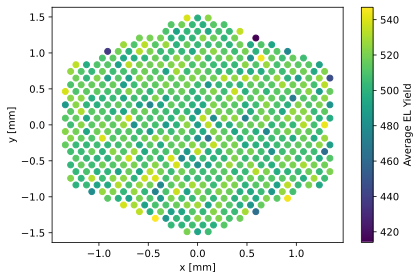

In [ ]:
plt.figure()

# plt.scatter(meta_slim["start x"], meta_slim["start y"], c=meta_slim["excitation"])
sc = plt.scatter(meta_avg["x"], meta_avg["y"], c=meta_avg["excitation"])
plt.colorbar(sc, label='Average EL Yield')
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
# plt.xlim(-1.5, 1.5)
# plt.ylim(-2., 2.)
plt.tight_layout() 
plt.savefig("../Plots/"+Mode[0]+"/Yield_vs_XYpos.pdf")
plt.show()

Text(0, 0.5, 'Counts')

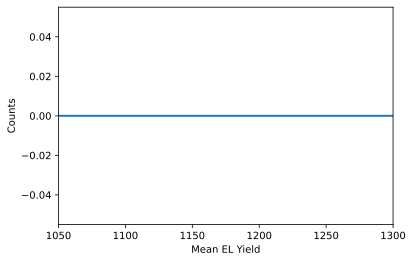

In [ ]:
# Bin the EL light for each electron in mean binned map of x,y
plt.figure()
plt.hist(meta_avg["excitation"],  bins = np.arange(800, 1400, 10),histtype="step", linewidth=2,)
plt.xlim(1050, 1300)
plt.xlabel("Mean EL Yield")
plt.ylabel("Counts")


1.3124899999999997
-1.3128099999999996


event  excitation         q         r        x         y
0         1         542  0.611933 -0.281414  1.23791 -0.640231
1         2         539  0.020010 -0.164383 -0.16335 -0.373979
2         3         527  0.356461 -0.279462  0.56935 -0.635789
3         4         470 -0.015004  0.306437  0.36309  0.697159
4         5         534 -0.355838  0.090336 -0.81613  0.205519
...     ...         ...       ...       ...      ...       ...
5745    996         546  0.464753 -0.017942  1.19734 -0.040820
5746    997         478  0.161475 -0.317774  0.00680 -0.722951
5747    998         436 -0.145399  0.518578  0.29919  1.179790
5748    999         534 -0.407790  0.157178 -0.86481  0.357589
5749   1000         553 -0.585181  0.379742 -1.03848  0.863931

[5750 rows x 6 columns]

Calculating value:  0.1
Calculating value:  0.35
Calculating value:  0.6
Calculating value:  0.8499999999999999
Calculating value:  1.0999999999999999


/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


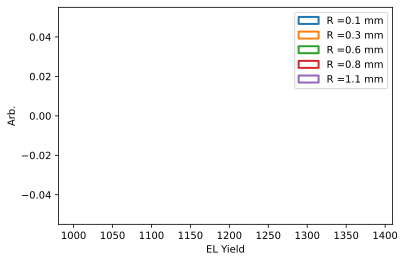

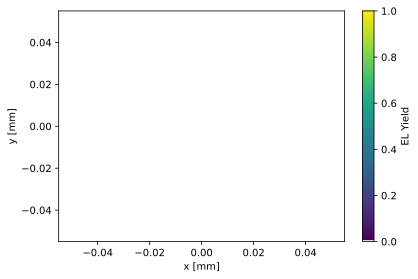

In [ ]:
# Convert q and r back to x and y values (now should be in unit cell)
meta_slim_copy["x"] = hexsize * (np.sqrt(3)*meta_slim_copy["q"].astype(float) + 0.5*np.sqrt(3)*meta_slim_copy["r"].astype(float))
meta_slim_copy["y"] = hexsize * 1.5*meta_slim_copy["r"].astype(float)
print(meta_slim_copy.x.max())
print(meta_slim_copy.x.min())
display(meta_slim_copy)

plt.figure()

# Plot the total EL yield for each configuration

# Apply a radial cut
range_ = np.arange(0.1, 1.3, 0.25)
for c in range_:
    print("Calculating value: ", c)
    cutval = c
    rad_cut = meta_slim_copy[ np.sqrt(meta_slim_copy['x']*meta_slim_copy['x'] + meta_slim_copy['y']*meta_slim_copy['y']) <= cutval]['event'].unique()
    filtered_data = meta_slim_copy[meta_slim_copy.event.isin(rad_cut)]
    # display(filtered_data)

    # data_align_tot = filtered_data.pivot_table(columns=['event'], aggfunc='size').reset_index()
    # data_align_tot.columns = ['event', 'Yield']
    
    plt.hist(filtered_data['excitation'], bins = np.arange(1000, 1400, 10), histtype="step", density = True, linewidth=2, label='R ={0:.1f} mm'.format(c) )

plt.xlabel("EL Yield")
plt.ylabel("Arb.")
plt.legend(loc = 'upper right')

# Plot the x, y positions of the large excitation events
plt.figure()

# Select metadata columns where excitation is over some threshold
meta_large = meta_slim_copy[meta_slim_copy["excitation"] > 1175]


sc = plt.scatter(meta_large["x"], meta_large["y"], c=meta_large["excitation"])
plt.colorbar(sc, label='EL Yield')
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
# plt.xlim(-1.5, 1.5)
# plt.ylim(-2., 2.)
plt.tight_layout() 
plt.show()



Calculating value:  0.05
Calculating value:  0.060000000000000005
Calculating value:  0.07


/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Calculating value:  0.08000000000000002
Calculating value:  0.09000000000000001
Calculating value:  0.1


/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Calculating value:  0.11000000000000001
Calculating value:  0.12000000000000001
Calculating value:  0.13


/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Calculating value:  0.14
Calculating value:  0.15000000000000002


/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Calculating value:  0.16000000000000003
Calculating value:  0.17000000000000004


/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Calculating value:  0.18000000000000005
Calculating value:  0.19
Calculating value:  0.2


/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Calculating value:  0.21000000000000002
Calculating value:  0.22000000000000003
Calculating value:  0.23000000000000004
Calculating value:  0.24000000000000005


/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


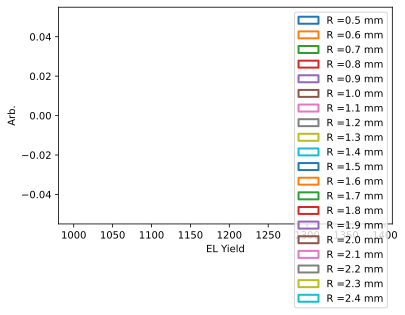

In [ ]:
# Make a side by side plot of the binned energy and the radial cut

plt.figure()

# Plot the total EL yield for each configuration

# Apply a radial cut
range_ = np.arange(0.05, 0.25, 0.01)
for c in range_:
    print("Calculating value: ", c)
    cutval = c
    rad_cut = data[ np.sqrt(data['x']*data['x'] + data['y']*data['y']) >= cutval]['event'].unique()
    filtered_data = data[~data.event.isin(rad_cut)]

    data_align_tot = filtered_data.pivot_table(columns=['event'], aggfunc='size').reset_index()
    data_align_tot.columns = ['event', 'Yield']
    plt.hist(data_align_tot['Yield'], bins = np.arange(1000, 1400, 10), histtype="step", density= True, linewidth=2, label='R ={0:.1f} mm'.format(c*10) )

plt.xlabel("EL Yield")
plt.ylabel("Arb.")
plt.legend(loc = 'upper right')
# plt.savefig("../Plots/"+Mode[1]+"/YieldTotal.pdf")

In [ ]:
# Plot the x, y positions of the large excitation events
plt.figure()

data_large_slim = data_large.drop_duplicates(subset = ["event"])

sc = plt.scatter(data_large_slim["start x"], data_large_slim["start y"], c=data_large_slim["excitation"])
plt.colorbar(sc, label='EL Yield')
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
# plt.xlim(-1.5, 1.5)
# plt.ylim(-2., 2.)
plt.tight_layout() 
plt.show()

NameError: name 'data_large' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
# Select metadata columns where excitation is over some threshold
meta_large = meta[meta["excitation"] > 1225]

# Merge dataframe to get start position in the data table
data_large= data.merge(meta_large, on="event", how = 'inner')


data_large = data_large.drop(columns=["electrons", "ions", "elastic", "ionisations", "attachment", "inelastic","top", "bottom", "start z", "start E", "end E"])


display(data_large)

# Make a plot of the timing profile of the EL emission
fig = plt.figure()
ax = fig.add_subplot()

count = 0
for i in data_large['event'].unique():
    if (count > 100): break
    ax.plot(data_large[data_large["event"] == i]['y'], data_large[data_large["event"] == i]['z'])
    count+=1

# ax.set_zlim(-0.8, 0.7)
# ax.set_xlim(-0.7, 0.7)
# ax.set_ylim(-0.7, 0.7)
# ax.invert_xaxis()

ax.set_xlabel("y [cm]")
ax.set_ylabel("z [cm]")
# ax.set_zlabel("z [cm]")

